In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import manifold
from scipy.spatial import distance
from rdkit.Chem import AllChem as Chem
from rdkit import DataStructs
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker
from rdkit.Chem import Draw
from rdkit.Chem.SaltRemover import SaltRemover

In [29]:
#read data - ChemblID, canonical smiles, standard value and standard unit
data_file = open("./data/beta_amyloidA4_protein_IC50.tsv")
data_file.readline() #read the header (remove it)
def splitter(line):
    spls = line.strip().split("\t")
    if spls[14] != "" and spls[15] == "nM":
        return (Chem.MolFromSmiles(spls[10]),float(spls[14]))
mols = [splitter(line) for line in data_file]
mols = [m for m in mols if m]
len(mols), mols[:3]

(785,
 [(<rdkit.Chem.rdchem.Mol at 0x1dd7833d080>, 2.8),
  (<rdkit.Chem.rdchem.Mol at 0x1dd79331260>, 4.5),
  (<rdkit.Chem.rdchem.Mol at 0x1dd79331440>, 5.5)])

### Remove inorganic structures

In [94]:
hasCarbonPatt = Chem.MolFromSmarts("[#6]")
onlyOrganicPatt = Chem.MolFromSmarts("[!#6;!#7;!#8;!#16;!F;!Cl;!Br;!I]")
mols_org = [[i for i in record] for record in mols_c if \
                    (record[0].HasSubstructMatch(hasCarbonPatt) and not record[0].HasSubstructMatch(onlyOrganicPatt))]
len(mols), len(mols_org)

(785, 768)

### Remove salts

In [106]:
remover = SaltRemover()
mols_org_desalt = [remover(record[0]) for record in mols_org]
mols_org_desalt[:1]

In [107]:
len(mols_org), len(mols_org_desalt)

(768, 768)

In [108]:
concentrations = [record[1] for record in mols_org]
mols_org_desalt = list(zip(mols_org_desalt, concentrations))
mols = mols_org_desalt
len(mols), mols[:1]

(768, [(<rdkit.Chem.rdchem.Mol at 0x1dd7d4ae760>, 2.8)])

# MDS

### Prepare distance matrix

In [111]:
fps = [Chem.GetMorganFingerprintAsBitVect(m[0],2,nBits=1024) for m in mols]
fps[:2]

In [112]:
sparse_mat = distance.pdist(fps,metric="jaccard")
dist_mat = distance.squareform(sparse_mat)

### Calculate new 2D coordinates with MDS

In [113]:
clf = manifold.MDS(n_components=2, n_init=1, max_iter=100, dissimilarity="precomputed")
X_mds = clf.fit_transform(dist_mat)

##### Function visualising 2D points

In [114]:

#----------------------------------------------------------------------
# Scale and visualize the embedding vectors
def plot_embedding(X, title=None, highlights=[]):
    fig = plt.figure()
    # ax = plt.subplot(111)
    for i, point in enumerate(X):
        x,y = point
        if i in highlights:
            plt.plot([x],[y],"r.", markersize=4)
        else:
            plt.plot([x],[y],"k.", markersize=1)
    # plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)
    return fig

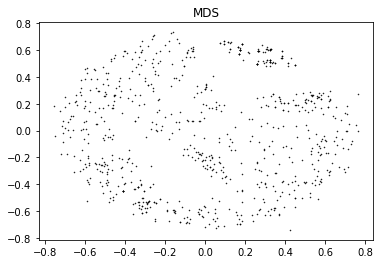

In [115]:
plot_embedding(X_mds,"MDS")

### What about if we highlight molecules with very low activity?

In [122]:
inactive_idxs = []
for i in range(len(mols) -1):
    if mols[i][1] >= 10000:
        inactive_idxs.append(i)
len(inactive_idxs)

238

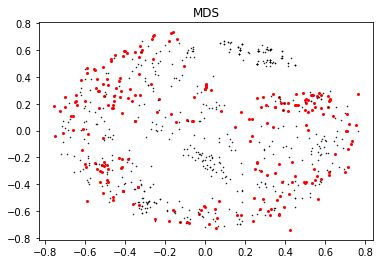

In [123]:
plot_embedding(X_mds,"MDS",highlights=inactive_idxs)

# PCA

In [124]:
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors as rdescriptors

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [159]:
attribute_array = list([Descriptors.MolWt(m[0]), Descriptors.MolLogP(m[0]),
                       rdescriptors.CalcNumLipinskiHBA(m[0]),
                       rdescriptors.CalcNumLipinskiHBD(m[0])] for m in mols)

In [168]:
X = np.array(attribute_array)

scaler = StandardScaler()
scaler.fit(X)
Y = scaler.transform(X)
spca = PCA(n_components=2)
spca.fit(Y)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [169]:
print(spca.explained_variance_ratio_)

[ 0.48588855  0.36493939]


In [186]:
principalComponents = pca.fit_transform(X)
principalComponents

array([[  1.62747048e+02,   3.93685217e-02],
       [  2.36818493e+01,  -1.21436903e+00],
       [  1.47734059e+02,  -2.67569602e-01],
       ..., 
       [  1.11990765e+01,  -8.97367715e-01],
       [ -1.58975199e+02,   9.02651044e-01],
       [ -1.80004409e+02,  -2.65809211e-01]])

In [187]:
activity = [record[1] for record in mols]
activity[:3]

[2.8, 4.5, 5.5]

#### Plot principal components with color mapped activity

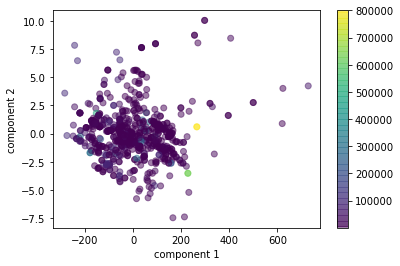

In [190]:
plt.scatter(principalComponents[:, 0], principalComponents[:, 1],
            c=activity, alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()
plt.show()